>> To access .pth file of the trained models, visit [THIS LINK](https://drive.google.com/drive/folders/177e0mZuIOq89xteOZ4DtSW3R2aP7uXng?usp=drive_link).

## Image Captions Using CNN and LSTM

Image captioning is a challenging artificial intelligence task that involves generating textual descriptions for images. It combines the prowess of Convolutional Neural Networks (CNNs) for image feature extraction and Recurrent Neural Networks (RNNs), especially Long Short-Term Memory (LSTM) networks, for sequence modeling. An encoder-decoder structure is commonly used for this purpose. 

The encoder-decoder framework is a popular model architecture in deep learning, particularly for tasks that involve transforming input data into output sequences, such as machine translation, image captioning, and more; ***Encoder*** encodes the input data (e.g., an image) into a high-dimensional feature space and the ***Decoder*** decodes the encoded features into a desired output sequence (e.g., a caption).

### Components of the Image Captioning Model

1. **Convolutional Neural Network (ResNet 18) as an Encoder:**
   - **ResNet 18:** ResNet (Residual Network) is a deep learning model designed to overcome the vanishing gradient problem in deep networks. ResNet 18 is a relatively shallower version with 18 layers. It utilizes residual blocks which allow gradients to flow through the network effectively.
   - **Feature Extraction:** The CNN processes the input image and generates a fixed-size feature map, which captures essential characteristics of the image. The typical approach is to use pre-trained ResNet models (trained on large datasets like ImageNet) and then fine-tune or directly use their feature maps for the captioning task.

2. **Long Short-Term Memory (LSTM) as a Decoder:**
   - **LSTM Network:** LSTM, a variant of RNN, is particularly effective for sequence prediction tasks because of its ability to manage long-term dependencies through its memory cell architecture.
   - **Sequence Generation:** The LSTM network takes the encoded image features and generates word sequences (captions), considering the temporal context.


In [8]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display


from PIL import Image
from textwrap import wrap

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

## Data Preparation and Preprocessing

### Loading Database and Exploring Contents

By setting up the image path and loading the captions, we are preparing the necessary data for training our CNN-LSTM image captioning model. The image path directs where to find the image files, and the DataFrame df_captions holds the textual data needed for generating captions.

In [9]:
# load data to pandas dataframe
image_path = '/Users/macbook/Documents/VSC/Python/idk/flickr8k/Images'
df_captions = pd.read_csv('/Users/macbook/Documents/VSC/Python/idk/flickr8k/captions.txt')
df_captions.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [10]:
print(f'Number of captions: {len(df_captions)}')
print(f'Maximum captions length: {df_captions["caption"].apply(len).max()}')
print(f'Number of images in the dataframe: {len(df_captions.drop_duplicates("image"))}')
print(f'Number of images in the directory: {len(os.listdir(image_path))}')
to_tensor = transforms.ToTensor()
image = Image.open(f"{image_path}/{df_captions.image[0]}")
image_tensor = to_tensor(image)
print(f'Original image shape: {image_tensor.shape}')

Number of captions: 40455
Maximum captions length: 199
Number of images in the dataframe: 8091
Number of images in the directory: 8091
Original image shape: torch.Size([3, 500, 375])


### Visualizing Images and Captions

In [11]:
def showImages(df):
    plt.figure(figsize = (20 , 15))
    n = 0
    for i in range(15):
        n += 1
        plt.subplot(3 , 5, n)

        image = Image.open(f"{image_path}/{df.image[i]}")

        plt.title("\n".join(wrap(df.caption[i], 32)))
        plt.axis("off")
        plt.imshow(image)

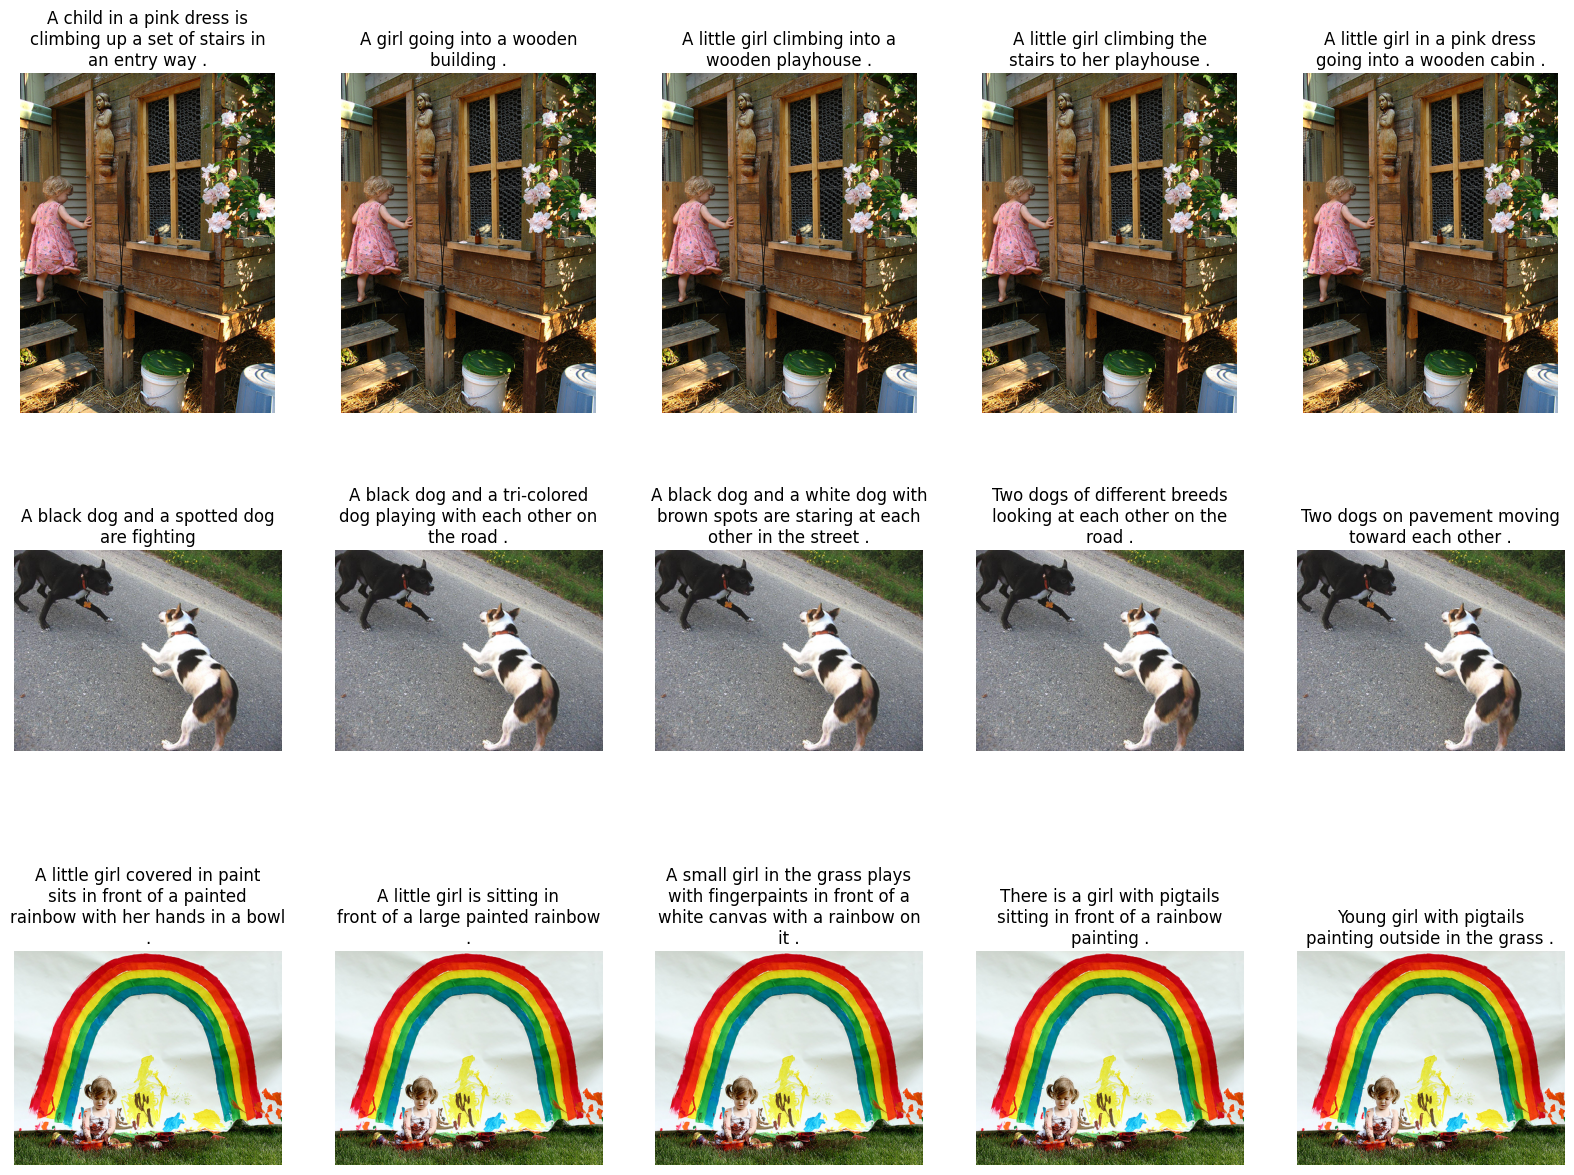

In [12]:
showImages(df_captions)

### Caption Preprocessing

This function, takes a text caption as input and performs several preprocessing steps to clean and format it:

- Converts the caption to lowercase to ensure uniformity.
- Removes special characters and punctuation using regular expressions, retaining only alphabetic characters and spaces.
- Normalizes whitespaces by removing additional spaces.
- Strips leading and trailing spaces from the caption.
- Finally, wraps the cleaned caption with `<SOS>` (start of sentence) and `<EOF>` (end of sentence) tokens, which are useful markers for training sequence models like LSTM.

By cleaning and preprocessing the captions, we standardize the input text and make it more suitable for training the CNN-LSTM model. The markers `<SOS>` and `<EOF>` will help the model recognize the beginning and end of each caption, which is crucial for accurate sequence prediction.


In [13]:
def process_caption(caption):
    caption = caption.lower()  # convert to lowercase
    caption = re.sub(r'[^\w\s]', '', caption)  # delete special chars, punctuations, etc.,
    caption = re.sub(r'\s+', ' ', caption)  # delete additional spaces
    caption = caption.strip()
    return f'<SOS> {caption} <EOS>'

df_captions['clean'] = df_captions['caption'].astype('string')
df_captions['clean'] = df_captions['clean'].apply(process_caption)

df_captions.head()

,image,caption,clean
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,<SOS> a child in a pink dress is climbing up a...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,<SOS> a girl going into a wooden building <EOS>
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,<SOS> a little girl climbing into a wooden pla...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,<SOS> a little girl climbing the stairs to her...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,<SOS> a little girl in a pink dress going into...


Maximum raw captions length: 199
Maximum clean captions length: 206


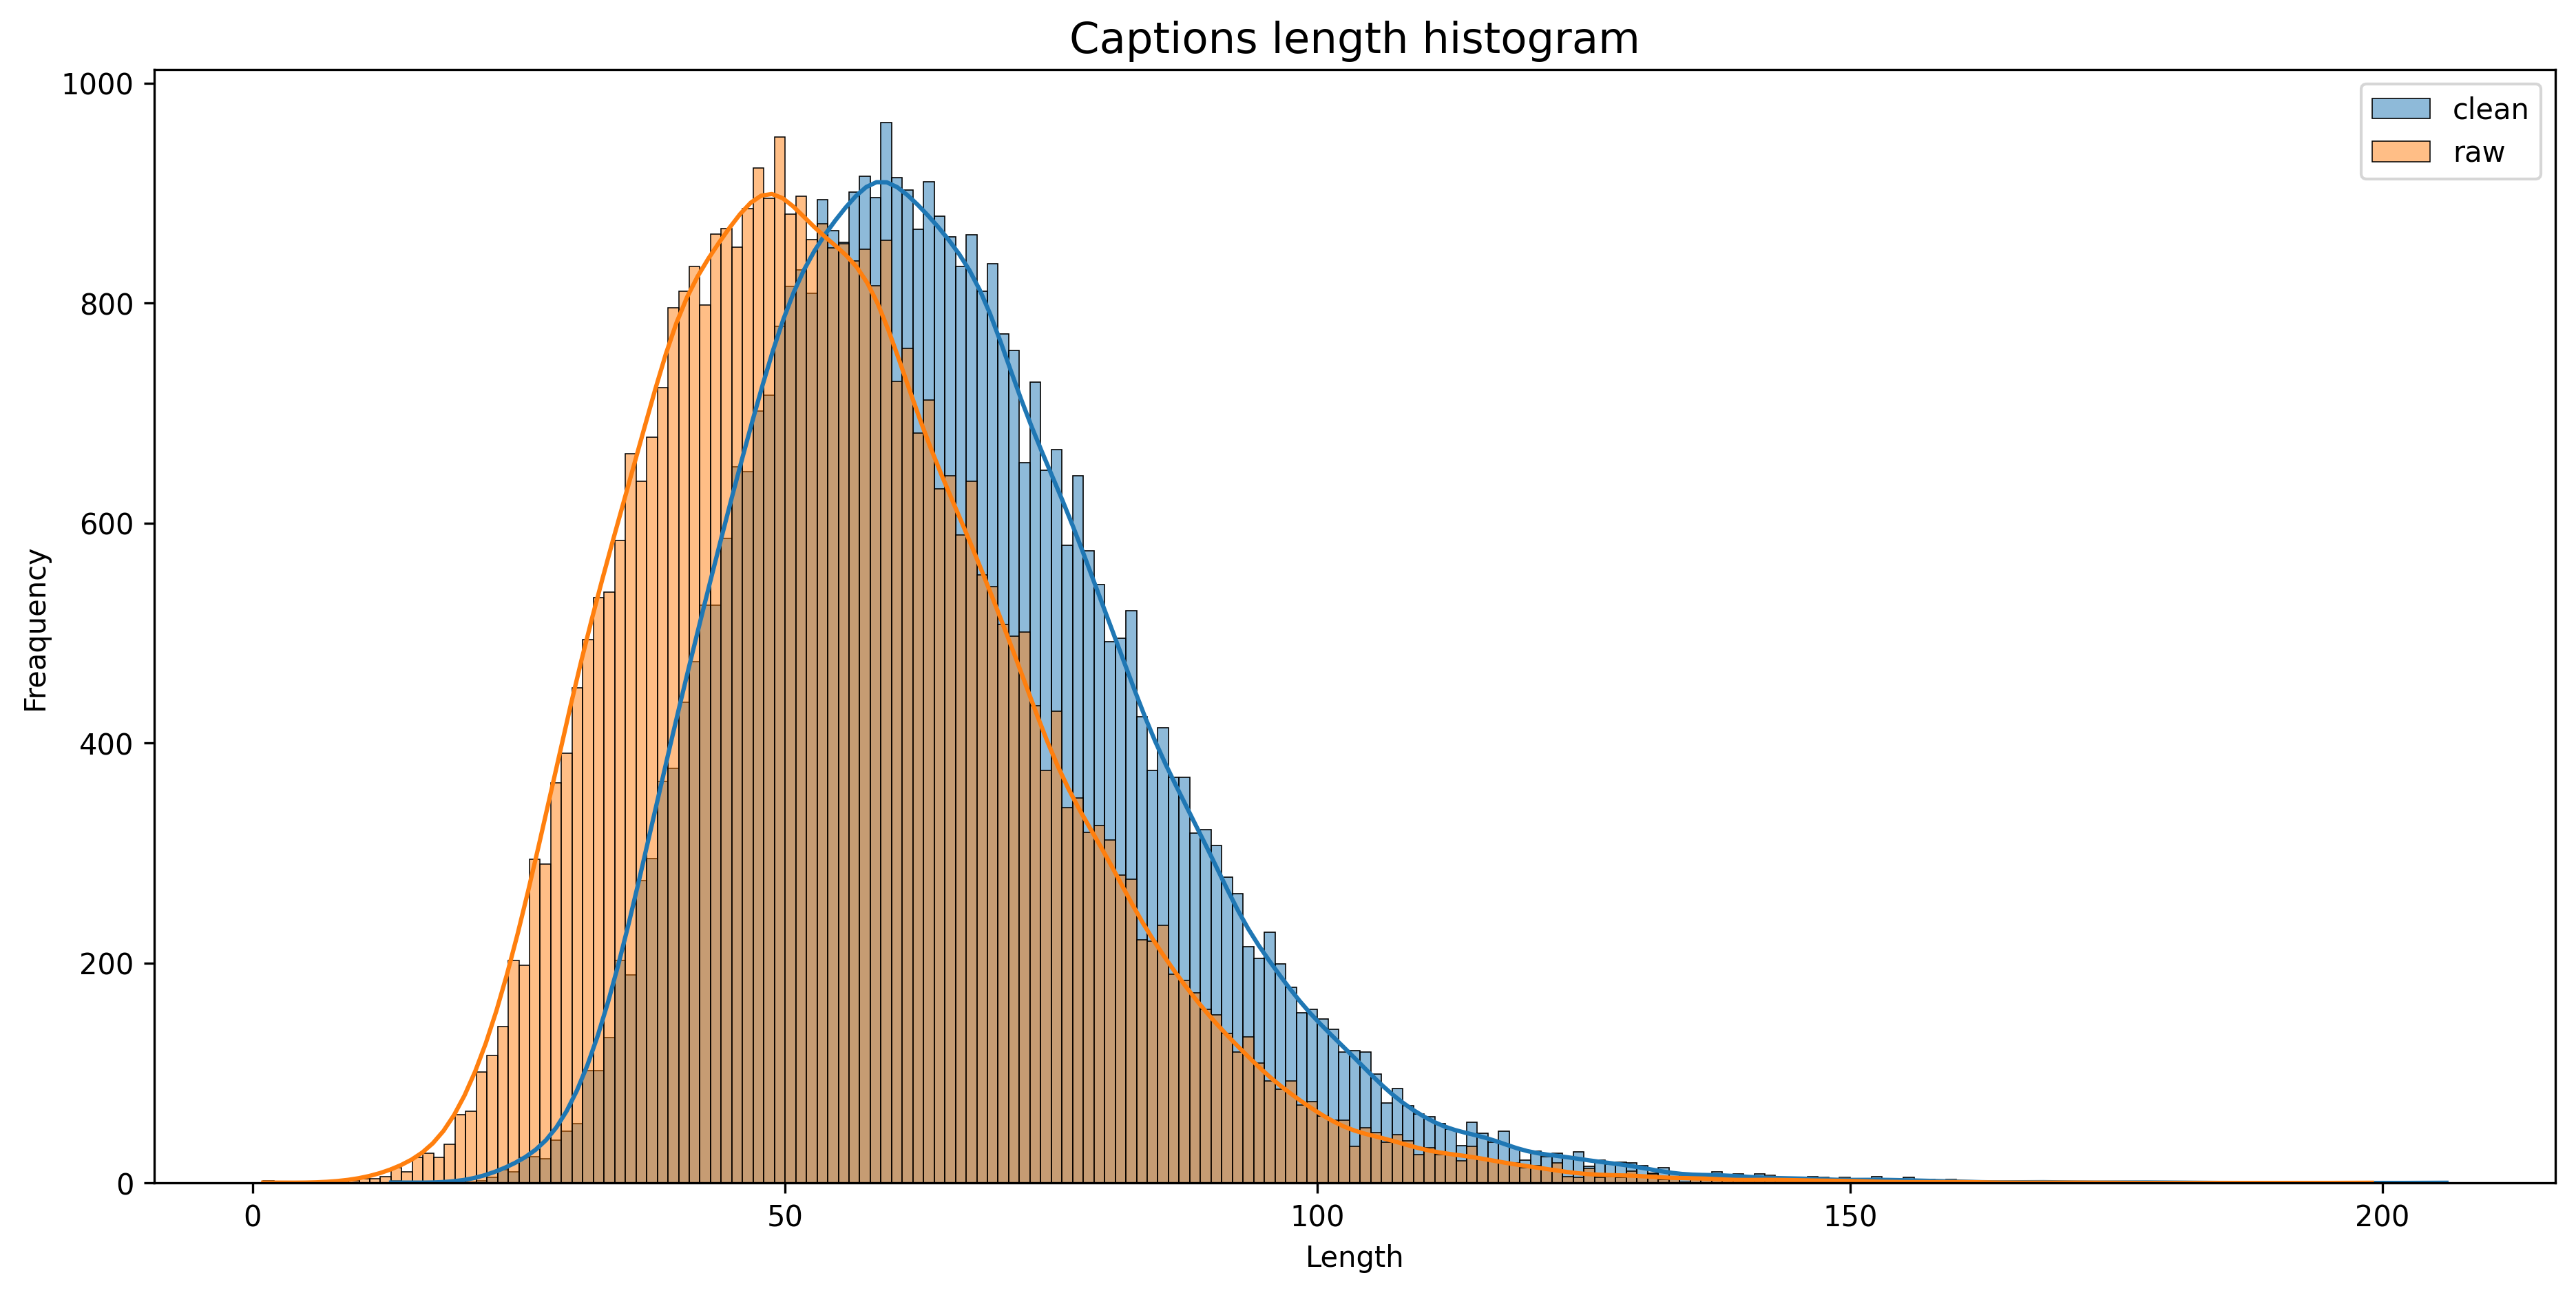

In [14]:
def captions_length(df):
    plt.figure(figsize=(15, 7), dpi=300)
    #sns.set_style('darkgrid')
    sns.histplot(x=df_captions["clean"].apply(len), kde=True, binwidth=1, label='clean')
    sns.histplot(x=df_captions["caption"].apply(len), kde=True, binwidth=1, label='raw')
    plt.title('Captions length histogram', fontsize=15)
    plt.xlabel('Length')
    plt.ylabel('Freaquency')
    plt.legend()
    plt.show()

print(f'Maximum raw captions length: {df_captions["caption"].apply(len).max()}')
print(f'Maximum clean captions length: {df_captions["clean"].apply(len).max()}')
captions_length(df_captions["clean"])

In [15]:
df = df_captions.drop('caption', axis=1)
df = df.rename(columns={"clean": "caption"})
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,<SOS> a child in a pink dress is climbing up a...
1,1000268201_693b08cb0e.jpg,<SOS> a girl going into a wooden building <EOS>
2,1000268201_693b08cb0e.jpg,<SOS> a little girl climbing into a wooden pla...
3,1000268201_693b08cb0e.jpg,<SOS> a little girl climbing the stairs to her...
4,1000268201_693b08cb0e.jpg,<SOS> a little girl in a pink dress going into...


In [16]:
captions = df['caption'].tolist()
print(type(captions))
print(captions[0].split())

<class 'list'>
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', '<EOS>']


By default, Keras starts fitting on the text from index 1 and reserves index 0 for padding. We manually add the token for padding. Note that the < and > characters used in our tokens should not be deleted so we omit them from the default filter.

In [17]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=False) 
tokenizer.fit_on_texts(captions)
tokenizer.word_index['<PAD>'] = 0 
vocab_size = len(tokenizer.word_index)

caption_sequences = tokenizer.texts_to_sequences(captions) # Convert captions to sequences
max_length = max(len(cp.split()) for cp in captions)


print('Vocab Size: ', vocab_size)
print('Max Length: ', max_length)
seq = tokenizer.texts_to_sequences([captions[1]])
print('Sample Sequence: ', seq[0])
txt =  tokenizer.sequences_to_texts(seq)
print("Sample Caption (Decoded):",txt[0])
print('Sample Caption: ', captions[1])


Vocab Size:  8831
Max Length:  38
Sample Sequence:  [2, 1, 19, 314, 64, 1, 194, 117, 3]
Sample Caption (Decoded): <SOS> a girl going into a wooden building <EOS>
Sample Caption:  <SOS> a girl going into a wooden building <EOS>


As can be seen, the `sequences_to_texts` function ignores the padding index.

In [18]:
max_length = max(len(seq) for seq in caption_sequences)
padded_sequences = pad_sequences(caption_sequences, maxlen=max_length, padding='post')

print('Sample Paddded Caption: ', padded_sequences[0].tolist())
seq = tokenizer.sequences_to_texts([padded_sequences[0].tolist()])
print('Sample Sequence: ', seq[0])
txt =  tokenizer.texts_to_sequences(seq)
print("Sample Caption (Decoded):",txt[0])


Sample Paddded Caption:  [2, 1, 42, 4, 1, 90, 170, 7, 119, 53, 1, 395, 12, 392, 4, 28, 5223, 693, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sample Sequence:  <SOS> a child in a pink dress is climbing up a set of stairs in an entry way <EOS>
Sample Caption (Decoded): [2, 1, 42, 4, 1, 90, 170, 7, 119, 53, 1, 395, 12, 392, 4, 28, 5223, 693, 3]


In [19]:
unique_images = df['image'].unique()
train_images, val_images = train_test_split(unique_images, test_size=0.15, random_state=42)

train_df = df[df['image'].isin(train_images)].reset_index()
train_df = train_df.drop('index', axis=1)
val_df = df[df['image'].isin(val_images)].reset_index()
val_df = val_df.drop('index', axis=1)

print("Total images:", len(unique_images))
print("Training images:", len(train_images))
print("Testing images:", len(val_images))
print("Training samples:", len(train_df))
print("Testing samples:", len(val_df))


Total images: 8091
Training images: 6877
Testing images: 1214
Training samples: 34385
Testing samples: 6070


### Building PyTorch Dataset and Dataloader

***Building the Dataset***

The `ImageCaptioningDataset` class is a custom dataset class inherited from PyTorch's `Dataset` module. Its instances are created by providing the following parameters:
   - `dataframe`: The DataFrame containing image paths and corresponding captions.
   - `img_dir`: The directory where the image files are stored.
   - `max_length`: The maximum length of the caption sequences after padding.
   - `tokenizer`: A tokenizer that converts words to integers based on the fitting to the vocabulary.
   - `transform`: Optional transformations to be applied to each image (such as resizing, normalization).

`__init__`: captions are tokenized and turned into sequences of integers. These sequences are then padded to a fixed length (`max_length`) to ensure consistency for batch processing. Padding is typically applied to the end (`post`) of the sequences.
`__len__`:  returns the total number of items in the dataset (i.e., the number of images/captions).
`__getitem__`: retrieves an individual item from the dataset. It loads an image by its index, applies necessary transformations, and pairs it with the corresponding padded caption sequence, returning both as a tuple.

***Image Transformation***

Image transformation pipeline is set using PyTorch's `transforms.Compose`, which includes:
- Resizing the image to 112x112 pixels.
- Converting the image to a PyTorch tensor.
- Normalizing the image tensor with predefined mean and standard deviation values (based on the ImageNet dataset).

***Dataset and DataLoader Instantiation***

Two instances of `ImageCaptioningDataset` are created, one for training (`train_dataset`) and one for validation (`val_dataset`), using the training and validation DataFrames (`train_df` and `val_df`), and the aforementioned `img_dir`, `max_length`, `tokenizer`, and `transform`.

Finally, the `DataLoader` objects, `train_dataloader` and `val_dataloader`, are created to feed data into the model in batches of size 32, with the data being shuffled to ensure randomization which helps during the training phase to reduce overfitting and improve generalization.

In [20]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataframe, img_dir, max_length, tokenizer, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        caption_sequences = tokenizer.texts_to_sequences(dataframe['caption'].tolist())
        self.padded_sequences = pad_sequences(caption_sequences, maxlen=max_length, padding='post')

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['image']
        image = Image.open(f"{self.img_dir}/{img_name}")
        caption = torch.tensor(self.padded_sequences[idx], dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, caption

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset
train_dataset = ImageCaptioningDataset(dataframe=train_df, img_dir=image_path, max_length=max_length, tokenizer=tokenizer, transform=transform)
val_dataset = ImageCaptioningDataset(dataframe=val_df, img_dir=image_path, max_length=max_length, tokenizer=tokenizer, transform=transform)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

## Model Architecture

To build a robust image captioning model, we employ a Convolutional Neural Network (CNN) as the encoder and a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) units as the decoder. The following code outlines this architecture

### Encoder
The `EncoderCNN` class uses a pre-trained ResNet18 model to extract features from input images. Depending on the `freeze_resnet` parameter, the ResNet layers may be frozen to leverage pre-trained weights without updating them. The extracted features are then transformed using a fully connected layer, batch normalization, and dropout to produce embeddings suitable for further processing in the LSTM model. The following provides a detailed explanation of the model:

The constructor takes two arguments: `freeze_resnet` (a boolean indicating whether to freeze the ResNet layers) and `embed_size` (the size of the embedding vectors). A pre-trained ResNet18 model is loaded. The final fully connected layer (classifier) of ResNet18 is removed because we only need the feature extractor part. The remaining layers are combined into a sequential container.

Three additional layers are added:

- `self.fc`: A fully connected layer that maps the ResNet output features to the specified `embed_size`.
- `self.bn`: A batch normalization layer that normalizes the output of the fully connected layer, improving the stability and performance of the network.
- `self.dropout`: A dropout layer with a 50% dropout rate. It helps prevent overfitting by randomly setting a portion of the input units to zero during training.

The `forward` method defines how the data passes through the network:

1. **Feature Extraction**: The input images are passed through the ResNet18 feature extractor (`self.resnet`). The resulting feature maps are reshaped to a 2D tensor of shape `(batch_size, -1)`.
   
2. **Dropout**: The features are processed by the dropout layer, which helps mitigate overfitting.
   
3. **Fully Connected Layer**: The features are then passed through the fully connected layer (`self.fc`), mapping them to the desired embedding size.
   
4. **Batch Normalization**: The output of the fully connected layer is normalized by the batch normalization layer (`self.bn`).

Finally, the processed features are returned as the output.

### Decoder

The `DecoderRNN` class takes image features and target captions to generate a sequence of words as the output caption. It uses an embedding layer to convert words to dense vectors, an LSTM network to model the sequences, a skip connection to integrate image features directly into the LSTM outputs, and a final dense layer to map the hidden states to vocabulary logits. Dropout layers are used for regularization to prevent overfitting. The following markdown explains the class in more details:


The `Embedding` layer converts word indices into dense vectors of fixed size (`embed_size`). We also use a multi-layer LSTM:
- `embed_size`: Input size of each LSTM cell, which is the size of the embedding vectors.
- `hidden_size`: Number of features in the hidden state.
- `num_layers`: Number of stacked LSTM layers.
- `batch_first=True`: Input and output tensors are provided in the form `(batch_size, sequence_length, features)`.
- `dropout=0.5`: Dropout probability to prevent overfitting within the LSTM layers.

`self.dense` is a fully connected layer that takes concatenated features (output from LSTM and image features) and projects them to the hidden state size. `self.final` is also a fully connected layer that maps hidden states to the vocabulary size, preparing the logits for word prediction.

The `forward` method defines how data flows through the network. we first use embedding on captions and convert input captions to their respective embeddings. Then we concatenate the image features with the word embeddings along the sequence length dimension and feed it through the LSTM network.

We create a skip connection by concatenating the LSTM outputs with the replicated image features and the pass through an additional dense layer and apply ReLU activation. Finally, we map the processed features to the vocabulary size, generating logits for each word in the vocabulary. For the output, we skip the first token from the output sequences (associated with the concatenated image features) before returning the final output.

In [21]:
class EncoderCNN(nn.Module):
    def __init__(self, freeze_resnet, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet18(weights='DEFAULT')

        if freeze_resnet:
            for param in resnet.parameters():
                param.requires_grad = False

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.dropout(features)
        features = self.fc(features)
        features = self.bn(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=4):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=0.5)
        self.dense = nn.Linear(hidden_size + embed_size, hidden_size,)  # New dense layer
        self.final = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        hiddens = self.dropout(hiddens)
        # Skip connection: concatenate LSTM output with image features
        skip_connection = torch.cat((hiddens, features.unsqueeze(1).expand(-1, hiddens.size(1), -1)), dim=2)
        # Apply dense layer and dropout
        x = self.dense(skip_connection)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        
        # Final layer (no activation, as it will be handled by CrossEntropyLoss)
        outputs = self.final(x)
        
        return outputs[:, 1:, :]

class CNNtoRNN(nn.Module):
    def __init__(self, freeze_resnet, embed_size, hidden_size, vocab_size, num_layers=2):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(freeze_resnet, embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs


## Train

We initializes a CNN-RNN model for image captioning, set up the loss function and optimizer, and determines the appropriate device for computation (CPU, GPU, or MPS). 

***Loss Function***

`criterion = nn.CrossEntropyLoss(ignore_index=0)`: Defines the loss function as CrossEntropyLoss, which is suitable for classification tasks. The `ignore_index=0` argument ensures that padding tokens (with index 0) are not considered while computing the loss.

***Optimizer***

`optimizer = optim.Adam(model.parameters(), lr=0.001)`: Initializes the Adam optimizer with a learning rate of 0.001 to update the model parameters during training. Adam is an adaptive learning rate optimization algorithm commonly used in deep learning.

In [27]:
# Initialize the model
embed_size = 256
hidden_size = 256
vocab_size = len(tokenizer.word_index)
model = CNNtoRNN(freeze_resnet=True, embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)

criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming 0 is the padding index
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_epoch = 0
train_losses = []
val_losses = []

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
print(vocab_size)
print(model.decoderRNN)
print(model.encoderCNN)

### Load Previously Trained Model

In [28]:
def load_checkpoint(filepath, this_model):
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    checkpoint = torch.load(filepath, map_location=device)
    this_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    st_epoch = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    train_loss = checkpoint['train_loss_history']
    val_loss = checkpoint['val_loss_history']
    return this_model, optimizer, st_epoch, loss, train_loss, val_loss

#model, optimizer, start_epoch, loss, train_losses, val_losses = load_checkpoint('best_model_epoch6.pth', model)


### Main Training Loop

In [35]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model = model.to(device)
num_epochs = 2  # Adjust as needed
ep = 0

best_val_loss = float('inf')
patience = 3
boob =False
epochs_without_improvement = 0

for epoch in range(start_epoch, start_epoch+num_epochs):
    model.train()
    total_train_loss = 0

    # Training loop
    for imgs, captions in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{start_epoch+num_epochs} - Training"):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:, :-1])

        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_train_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation loop
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for imgs, captions in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{start_epoch+num_epochs} - Validation"):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:, :-1])

            loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
            total_val_loss += loss.item()

    # Calculate average validation loss for the epoch
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    ep = epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the model when validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0

        # Save the best model
        torch.save({
            'epoch': ep,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'train_loss_history': train_losses,
            'val_loss_history': val_losses,
            'best_val_loss': best_val_loss,
        }, f'best_model_epoch{ep+1}.pth')

        print(f"New best model saved at epoch {ep+1}")
    else:
        epochs_without_improvement += 1

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

print("Training completed!")

# Save the final model
torch.save({
    'epoch': ep,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'train_loss_history': train_losses,
    'val_loss_history': val_losses,
    'best_val_loss': best_val_loss,
}, f'final_model_epoch.pth')


Epoch 7/8 - Validation: 100%|██████████| 190/190 [00:54<00:00,  3.47it/s]


Epoch [7/2], Train Loss: 3.2446, Val Loss: 3.3650
New best model saved at epoch 7


Epoch 8/8 - Validation: 100%|██████████| 190/190 [01:06<00:00,  2.85it/s]


Epoch [8/2], Train Loss: 3.2009, Val Loss: 3.3815
Training completed!


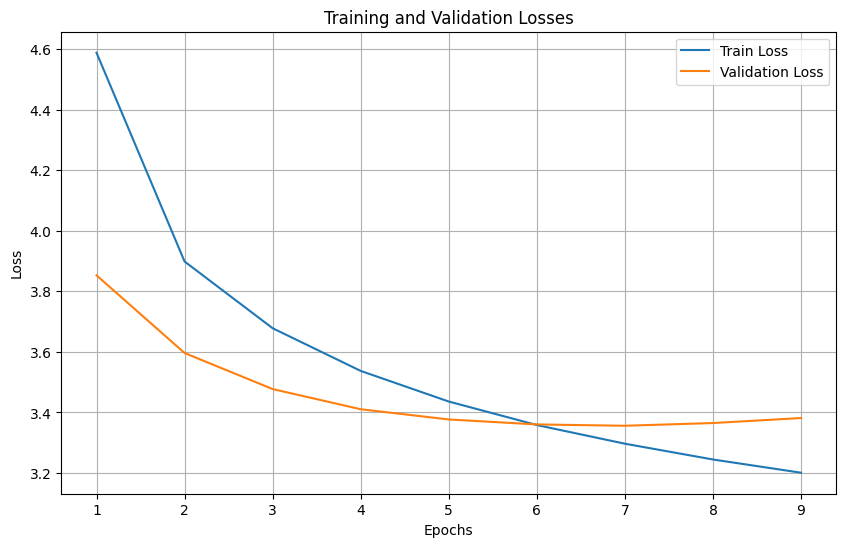

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


## Caption Generation

In [23]:
def generate_caption(this_model, image_name, tokenizer, max_length=30):
    this_model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(f'{image_path}/{image_name}').convert('RGB')
    image = transform(image).unsqueeze(0)

    device = next(this_model.parameters()).device
    image = image.to(device)
    
    caption = [tokenizer.word_index['<SOS>']]
    
    with torch.no_grad():
        features = this_model.encoderCNN(image).squeeze(0)  # Shape: [256]
        features = features.unsqueeze(0)  # Shape: [1, 256]
        states = None
        
        for _ in range(max_length):
            current_word = torch.tensor([caption[-1]]).to(device)
            
            # Embed the current word
            word_embed = this_model.decoderRNN.embed(current_word).unsqueeze(1)
            
            # Use only word embedding as LSTM input
            lstm_input = word_embed
            
            # LSTM forward pass
            hiddens, states = this_model.decoderRNN.lstm(lstm_input, states)
            
            # Ensure hiddens has the correct shape
            hiddens = hiddens.squeeze(1)  # Shape: [1, 256]
            
            # Concatenate LSTM output with image features
            combined = torch.cat((hiddens, features), dim=1)  # Shape: [1, 512]
            
            # Apply dense layer and activation
            x = this_model.decoderRNN.dense(combined)
            x = torch.relu(x)
            x = this_model.decoderRNN.dropout(x)
            
            # Final layer
            output = this_model.decoderRNN.final(x)

            # Apply softmax to get probabilities
            output_probs = torch.nn.functional.softmax(output, dim=1)
            
            # Get the word with the highest probability
            predicted_word_idx = output_probs.argmax(dim=1).item()
            
            caption.append(predicted_word_idx)
            
            if predicted_word_idx == tokenizer.word_index['<EOS>']:
                break
    
    return tokenizer.sequences_to_texts([caption])[0]

In [29]:
import heapq

def generate_caption_beam_search(this_model, image_name, tokenizer, beam_width=3, max_length=30):
    this_model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(f'{image_path}/{image_name}').convert('RGB')
    image = transform(image).unsqueeze(0)

    device = next(this_model.parameters()).device
    image = image.to(device)
    
    with torch.no_grad():
        features = this_model.encoderCNN(image).squeeze(0)  # Shape: [256]
        features = features.unsqueeze(0)  # Shape: [1, 256]
        
        # Initialize the beam
        beam = [(0, [tokenizer.word_index['<SOS>']], None)]
        completed_captions = []
        
        for _ in range(max_length):
            candidates = []
            
            for cumulative_score, caption, states in beam:
                if caption[-1] == tokenizer.word_index['<EOS>']:
                    completed_captions.append((cumulative_score, caption))
                    continue
                
                current_word = torch.tensor([caption[-1]]).to(device)
                word_embed = this_model.decoderRNN.embed(current_word).unsqueeze(1)
                lstm_input = word_embed
                
                hiddens, new_states = this_model.decoderRNN.lstm(lstm_input, states)
                hiddens = hiddens.squeeze(1)  # Shape: [1, 256]
                
                combined = torch.cat((hiddens, features), dim=1)  # Shape: [1, 512]
                
                x = this_model.decoderRNN.dense(combined)
                x = torch.relu(x)
                x = this_model.decoderRNN.dropout(x)
                
                output = this_model.decoderRNN.final(x)
                output_probs = torch.nn.functional.log_softmax(output, dim=1)
                
                top_k_probs, top_k_indices = output_probs.topk(beam_width)
                
                for i in range(beam_width):
                    score = top_k_probs[0][i].item()
                    word_idx = top_k_indices[0][i].item()
                    candidates.append((
                        cumulative_score + score,
                        caption + [word_idx],
                        new_states
                    ))
            
            # Select top beam_width candidates
            beam = heapq.nlargest(beam_width, candidates, key=lambda x: x[0])
            
            # Early stopping if all beams have ended
            if all(caption[-1] == tokenizer.word_index['<EOS>'] for _, caption, _ in beam):
                break
        
        # Add any unfinished captions to the completed list
        completed_captions.extend((score, caption) for score, caption, _ in beam)
        
        # Sort completed captions by score
        if completed_captions:
            best_caption = max(completed_captions, key=lambda x: x[0])[1]
        else:
            # If no completed captions, use the best incomplete caption
            best_caption = max(beam, key=lambda x: x[0])[1]
    
    # Ensure the caption ends with <EOS> token
    if best_caption[-1] != tokenizer.word_index['<EOS>']:
        best_caption.append(tokenizer.word_index['<EOS>'])
    
    return tokenizer.sequences_to_texts([best_caption])[0]


In [30]:
def show_results(this_model, testImg):
    test_images = testImg
    captions = [(generate_caption(this_model, img_name, tokenizer), generate_caption_beam_search(this_model, img_name, tokenizer, beam_width=3)) for img_name in test_images]

    fig, axes = plt.subplots(1, 5, figsize=(20, 5))

    axes = axes.flatten()
    for i, (img_name, caption) in enumerate(zip(test_images, captions)):
        img = Image.open(f'{image_path}/{img_name}')
        img_resized = img.resize((112, 112), Image.LANCZOS)
        axes[i].imshow(np.array(img))
        axes[i].axis('off')
        caption_final = r'$\mathbf{Greedy:}$ ' + f'{caption[0]}' + r'$\mathbf{Beam:}$ ' + f'{caption[1]}'
        axes[i].set_title("\n".join(wrap(caption_final, 32)))

    plt.tight_layout()
    plt.show()

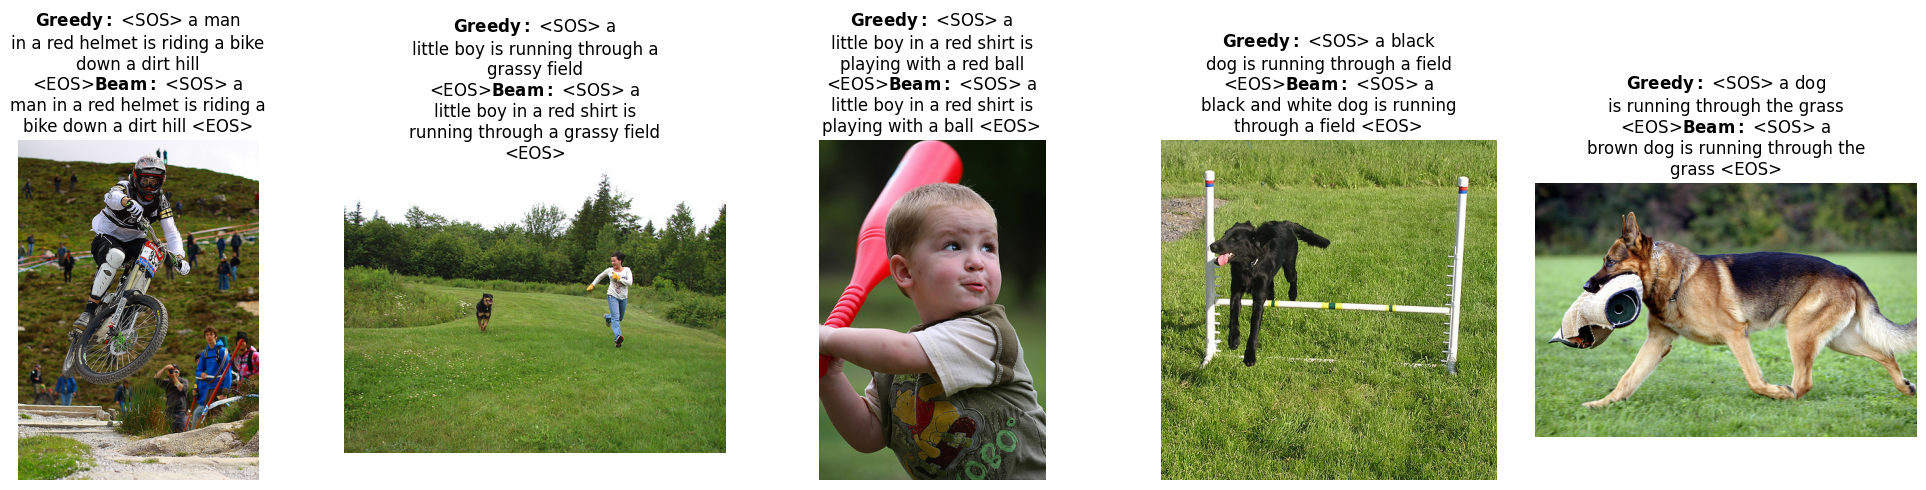

In [39]:
embed_size = 256
hidden_size = 256
vocab_size = len(tokenizer.word_index)

model_freeze = CNNtoRNN(freeze_resnet=True, embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)
model_freeze, _, _, _, train_losses_freeze, val_losses_freeze = load_checkpoint('CNN_LSTM_freeze.pth', model_freeze)

test_images = ['3606084228_6286a52875.jpg', '3705976184_53ae07e898.jpg', '2648165716_02e2e74fd6.jpg', 
                '2784625888_71a421e171.jpg', '3286198467_8880be127e.jpg']
show_results(model_freeze, test_images)

## ResNet18 Freeze/Unfreeze Comparison

### Observation

We once froze and then unfroze the ResNet parameters and trained the model. After training, the validation and training losses where plotted for both cases. The following can be observed:

**Frozen Mode**:
- The validation loss is lower than the training loss until epoch 6.
- After epoch 6, the training loss continues to decrease, while the validation loss gradually plateaus.
- Both curves are smooth and exhibit a downward trend.

**Unfrozen Mode**:
- The validation loss is consistently higher than the training loss.
- The training loss follows a smooth downward trend, whereas the validation loss fluctuates sharply up and down.

#### Explanation

***Frozen ResNet parameters***

Validation curve below training curve until epoch 6 suggests that initially, the model generalizes well to unseen data. The lower validation loss indicates that the model is not overfitting in the early stages of training. Also the fact that training curve continues to decrease while validation plateaus is a classic sign of overfitting. As the model continues to learn from the training data, it starts to memorize specific patterns that don't generalize well to the validation set. The plateau in the validation curve suggests that the model has reached its optimal generalization point around epoch 6 so it was a good decision to stop the training around this epoch. In addition, the smooth nature of both curves indicates stable learning. The frozen ResNet parameters provide a consistent feature extraction base, allowing the rest of the model to learn steadily.

***Unfrozen ResNet parameters***

Validation curve being always above the training curve suggests that the model is consistently performing better on the training data than on unseen data. It's a sign that the model might be overfitting from the beginning. Smooth downward trend in training curve; This indicates that the model is continuously improving its performance on the training data while sharp fluctuations in validation curve suggests that the model is very sensitive to changes in the ResNet parameters. As these parameters are updated, they can cause significant shifts in the feature representations, leading to unstable performance on the validation set.

***Underlying reasons***

1. Complexity and capacity: Unfreezing the ResNet parameters significantly increases the model's capacity to learn. This can lead to overfitting, especially if the dataset is not large enough to support learning so many parameters.

2. Feature stability: In the frozen case, the features extracted by ResNet remain constant, providing a stable base for the rest of the model to learn from. When unfrozen, these features are constantly changing, which can lead to instability in the learning process.

3. Learning rate sensitivity: Unfrozen models are often more sensitive to learning rates. If the learning rate is too high, it can cause sharp fluctuations in the validation loss as seen in our unfrozen case. Thats the reason that we trained our model with `lr = 0.0001` instead of usual `lr=0.001` which we used in the frozen model.

4. Generalization vs. memorization: The frozen model seems to find a good balance between generalization and memorization around epoch 6. The unfrozen model, with its higher capacity, may be more prone to memorizing the training data, leading to consistent overfitting.


5. Gradient Explosion: The erratic behavior of the validation loss curve in the unfrozen model scenario is a potential indicator of gradient explosion. When gradients become very large, they can cause drastic updates to the model parameters, leading to significant and unpredictable changes in model performance from one iteration to the next. Also, the fact that the training loss decreases smoothly while the validation loss fluctuates wildly could suggest that the model is adapting too quickly to the training data. This rapid adaptation could be driven by large gradient updates, potentially due to gradient explosion.

#### Why does gradient explosion occur in unfrozen scenario?

ResNet is a deep architecture. When we unfreeze its parameters, we're allowing gradients to flow through the entire network. In deep networks, gradients can accumulate as they backpropagate, potentially leading to explosion. Also, without proper gradient clipping, exploding gradients can cause large, destabilizing updates to the model parameters. In addition, in CNNs like ResNet, the magnitudes of feature maps can sometimes grow large, leading to large gradients during backpropagation. 

Although we have used batch normalization and dropouts to prevent gradient explosion and overfitting, we can suspect that the learning rate is still too large. Large learning rates combined with large gradients can exacerbate the explosion problem. We have solved this problem in the next model:


In [31]:
embed_size = 256
hidden_size = 256
vocab_size = len(tokenizer.word_index)

model_freeze = CNNtoRNN(freeze_resnet=True, embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)
model_freeze, _, _, _, train_losses_freeze, val_losses_freeze = load_checkpoint('CNN_LSTM_freeze.pth', model_freeze)

model_unfreeze = CNNtoRNN(freeze_resnet=False, embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)
model_unfreeze, _, _, _, train_losses_unfreeze, val_losses_unfreeze = load_checkpoint('CNN_LSTM_unfreeze.pth', model_unfreeze)

model_unfreeze_lr = CNNtoRNN(freeze_resnet=False, embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size)
model_unfreeze_lr, _, _, _, train_losses_unfreeze_lr, val_losses_unfreeze_lr = load_checkpoint('CNN_LSTM_unfreeze_lr.pth', model_unfreeze_lr)


### Plot

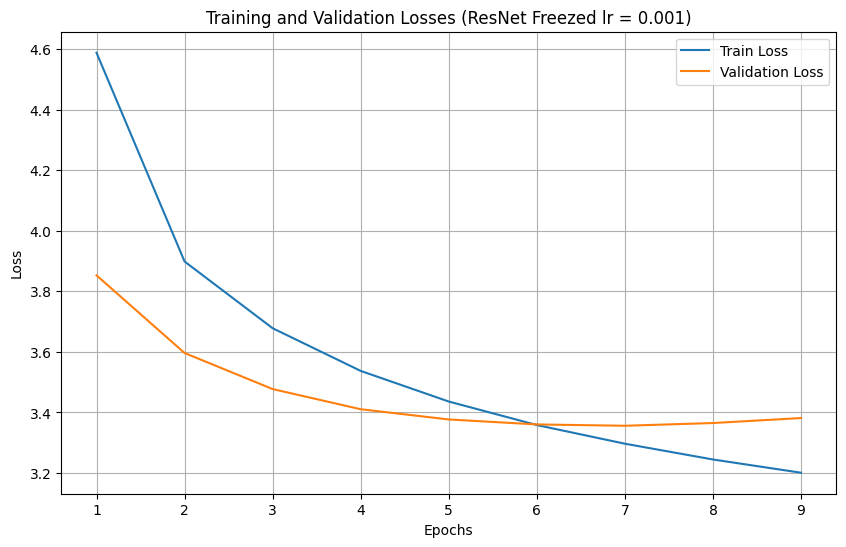

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_freeze) + 1), train_losses_freeze, label='Train Loss')
plt.plot(range(1, len(val_losses_freeze) + 1), val_losses_freeze, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (ResNet Freezed lr = 0.001)')
plt.legend()
plt.grid(True)
plt.show()


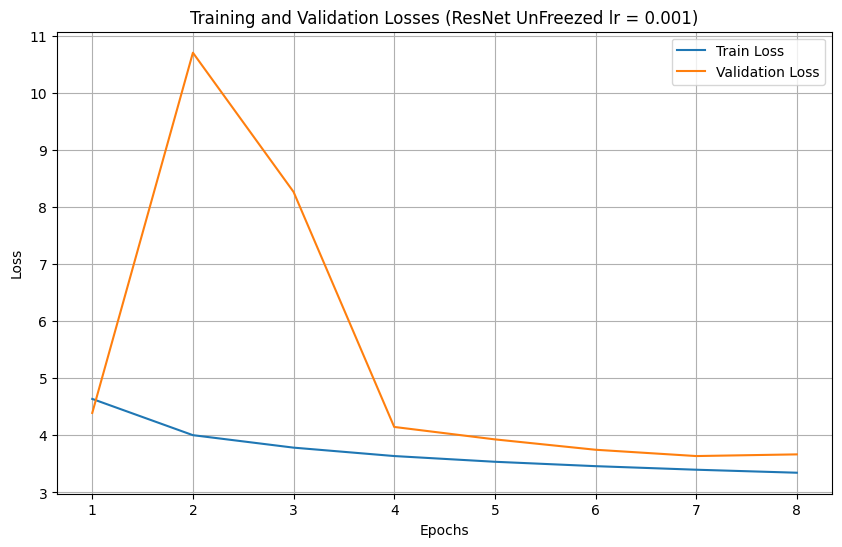

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_unfreeze) + 1), train_losses_unfreeze, label='Train Loss')
plt.plot(range(1, len(val_losses_unfreeze) + 1), val_losses_unfreeze, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (ResNet UnFreezed lr = 0.001)')
plt.legend()
plt.grid(True)
plt.show()


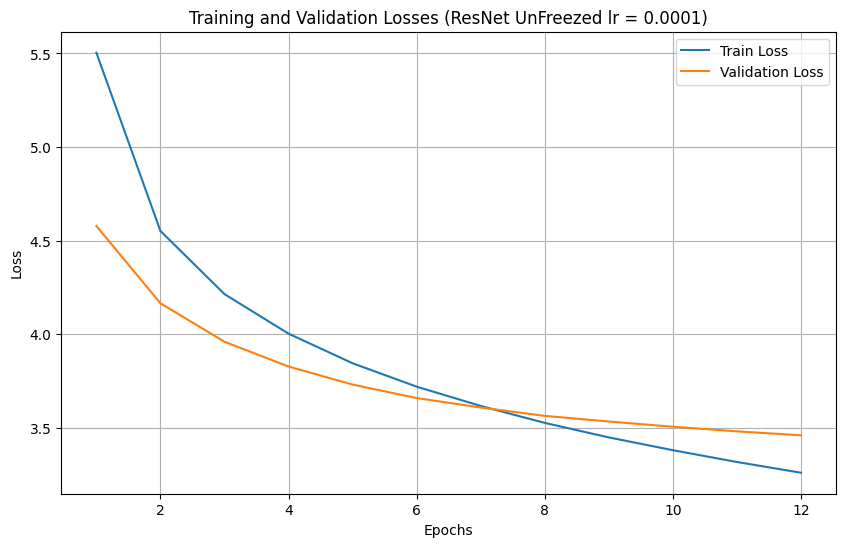

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_unfreeze_lr) + 1), train_losses_unfreeze_lr, label='Train Loss')
plt.plot(range(1, len(val_losses_unfreeze_lr) + 1), val_losses_unfreeze_lr, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses (ResNet UnFreezed lr = 0.0001)')
plt.legend()
plt.grid(True)
plt.show()


### BLEU Score

The results suggest that fine-tuning the entire model with a reduced learning rate is the most effective approach for this image captioning task. Beam search consistently provides better results than greedy search, though the improvement is more pronounced in the better-performing models and the difference is small in the case of the poorly performing unfreezed model with the original learning rate.

Simply unfreezing all layers without adjusting the learning rate leads to poor performance, highlighting the importance of careful fine-tuning strategies. Lowering the learning rate when unfreezing all layers is crucial. It allows the model to adapt pre-trained weights gradually, leading to the best performance.

The freezed ResNet model performs well, suggesting that the pre-trained ResNet features are already quite effective for this task. The best model (unfreezed with lower learning rate) shows a significant improvement over the freezed model, indicating that fine-tuning can indeed enhance performance when done correctly.


In [42]:
from nltk.translate.bleu_score import corpus_bleu
import nltk

# Download required NLTK data
nltk.download('punkt')

def calculate_bleu(df_val, this_model, beam=False):
    # Group captions by image
    grouped = df_val.groupby('image')['caption'].apply(list).reset_index()
    
    all_references = []
    all_hypotheses = []
    
    for _, row in grouped.iterrows():
        image_name = row['image']
        reference_captions = row['caption']
        
        # Generate a caption for this image using your model
        if beam:
            generated_caption = generate_caption_beam_search(this_model, image_name, tokenizer)
        else:
            generated_caption = generate_caption(this_model, image_name, tokenizer)

        all_references.append([cap.split() for cap in reference_captions])
        all_hypotheses.append(generated_caption.split())
    
    # Calculate BLEU score
    bleu_score = corpus_bleu(all_references, all_hypotheses)
    
    return bleu_score

[nltk_data] Downloading package punkt to /Users/macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
# Calculate BLEU score
bleu_score_freeze = calculate_bleu(val_df, model_freeze, False)
bleu_score_unfreeze = calculate_bleu(val_df, model_unfreeze, False)
bleu_score_unfreeze_lr = calculate_bleu(val_df, model_unfreeze_lr, False)

print('Overall BLEU Score using Greedy Search')
print(f"    Freezed ResNet: {bleu_score_freeze}")
print(f"    Unfreezed ResNet: {bleu_score_unfreeze}")
print(f"    Unfreezed ResNet (lower lr): {bleu_score_unfreeze_lr}")

Overall BLEU Score using Greedy Search
    Freezed ResNet: 0.17499008930478874
    Unfreezed ResNet: 0.10938311006306764
    Unfreezed ResNet (lower lr): 0.2037074841367129


In [44]:
# Calculate BLEU score
bleu_score_freeze = calculate_bleu(val_df, model_freeze, True)
bleu_score_unfreeze = calculate_bleu(val_df, model_unfreeze, True)
bleu_score_unfreeze_lr = calculate_bleu(val_df, model_unfreeze_lr, True)

print('Overall BLEU Score using Beam Search')
print(f"    Freezed ResNet: {bleu_score_freeze}")
print(f"    Unfreezed ResNet: {bleu_score_unfreeze}")
print(f"    Unfreezed ResNet (lower lr): {bleu_score_unfreeze_lr}")

Overall BLEU Score using Beam Search
    Freezed ResNet: 0.19869801373079918
    Unfreezed ResNet: 0.10352504205347494
    Unfreezed ResNet (lower lr): 0.22180096413072023
